## Alley et al. 2023

In [1]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Probit
import numpy as np
from scipy.stats import norm
from scipy.optimize import brent
import matplotlib.pyplot as plt

In [2]:
n_ds = 100
n_pts = 1000
d = 50
tau = 2
rho = 0.5
Sv = 1

In [3]:
#generate data
np.random.seed(6)

X = []
Z = []
T = []
Y_star = []
Y = []
U = []
E = []
V = []
Bh = []
Bg = []
Bm = []
B = []

for i in range(n_ds):
    x = np.random.multivariate_normal([0]*d, np.identity(d), size=n_pts)
    u = np.random.normal(0, 1, size=n_pts)
    e, v = np.random.multivariate_normal([0]*2, [[1, rho * Sv], [rho * Sv, Sv**2]], size=n_pts).T
    bh = np.random.normal(0, 1)
    bg = np.random.multivariate_normal([0]*d, np.identity(d))
    bm = np.random.multivariate_normal([0]*d, np.identity(d))
    b = np.random.normal(0, 1)
    zeros1 = np.random.choice(range(d), size=d - 5, replace=False)
    zeros2 = np.random.choice(range(d), size=d - 5, replace=False)
    bg[zeros1] = 0
    bm[zeros2] = 0
    z = bh + u
    t = list(map(lambda a: np.dot(bm, a), x)) + b * z + v
    y_star = list(map(lambda a: np.dot(bg, a), x)) + tau * t + e
    y = np.array(list(map(lambda x: int(x > 0), y_star)))
    X.append(x)
    Z.append(z)
    T.append(t)
    Y_star.append(y_star)
    Y.append(y)
    U.append(u)
    E.append(e)
    V.append(v)
    Bh.append(bh)
    Bg.append(bg)
    Bm.append(bm)
    B.append(b)

## Homogeneous treatment effect (with endogeneity)

### Probit_IV

In [4]:
tau_hat = []
for i in range(n_ds):
    #1st linear regression for T
    x_tRegr = np.concatenate((X[i], np.transpose([Z[i]])), axis=1)
    t_regr = linear_model.LinearRegression(fit_intercept=False)
    t_regr.fit(x_tRegr, T[i])
    t_hat = t_regr.predict(x_tRegr)
    v_hat = T[i] - t_hat
    
    #2nd probit regression for Y
    x_yRegr = np.concatenate((X[i], np.transpose([T[i]])), axis=1)
    y_prRegr = Probit(Y[i], x_yRegr).fit(disp=0)
    y_hat = y_prRegr.predict(x_yRegr)
    tau_hat.append(y_prRegr.params[-1])

In [5]:
tau_err = abs(np.array(tau_hat) - tau)

### Orthogonalized two-stage

In [6]:
#log-likelihood definitions
bigM = 1000
def k(tau, rho, b, su, sv):
    return np.sqrt(1 + 2 * rho * sv * tau + (sv**2 + su**2 * b**2) * tau**2)

def f(tau, rho, r_hat, q_hat, T, b, su, sv, v):
    if 1 - rho**2 <= 0:
        return bigM
    else:
        return (norm.ppf(r_hat) * k(tau, rho, b, su, sv) + tau * (T - q_hat) + rho/sv * v)/np.sqrt(1 - rho**2)

def l(tau, rho, Y, r_hat, q_hat, T, b, su, sv, v):
    tmp = norm.cdf(f(tau, rho, r_hat, q_hat, T, b, su, sv, v))
    if tmp == 0:
        if Y == 0:
            return 0
        else:
            return - bigM
    elif tmp == 1:
        if Y == 0:
            return - bigM
        else:
            return 0
    else:
        return Y * np.log(tmp) + (1 - Y) * np.log(1 - tmp)

In [7]:
#rho is a variable
def lfR(rho, tau, Y, r_hat, q_hat, T, b, su, sv, v):
    return -1/len(Y) * sum(l(tau, rho, Y[i], r_hat[i], q_hat[i], T[i], b, su, sv, v[i]) for i in range(len(Y)))

#tau is a variable
def lfT(tau, rho, Y, r_hat, q_hat, T, b, su, sv, v):
    return -1/len(Y) * sum(l(tau, rho, Y[i], r_hat[i], q_hat[i], T[i], b, su, sv, v[i]) for i in range(len(Y)))

In [ ]:
def minimizeLF(rho_init, data, niter=1):
    rho_cur = rho_init
    rho_lst = []
    tau_lst = []
    for i in range(niter):
        #fix rho; find tau
        resT = brent(lfT, args=(rho_cur, ) + data)
        tau_cur = resT
        tau_lst.append(tau_cur)
        #fix tau; find rho
        resR = brent(lfR, args=(tau_cur, ) + data)
        rho_cur = resR
        rho_lst.append(rho_cur)
        if i > 1 and abs(tau_lst[-1] - tau_lst[-2]) <= 0.001 and abs(tau_lst[-1] - tau_lst[-2]) <= 0.001:
            break
    return tau_lst, rho_lst

In [67]:
#for bootstrap; not currently used
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return -np.mean(term_0+term_1, axis=0)

In [ ]:
tau_hat1 = []
rho_hat = []
su_lst = []
sv_lst = []
b = 100
su_true = 1
sv_true = 1
for i in range(n_ds):
    #split sample into S1, S2, S3
    S1, tmpS = train_test_split(range(len(X[i])), train_size=0.33, random_state=2) #sometimes might give S1 that is fully separable for probit
    S2, S3 = train_test_split(range(len(tmpS)), train_size=0.5, random_state=2)
    #fit r_hat(x) with probit of Y on X
    r_prRegr = Probit(Y[i][S1], X[i][S1]).fit(disp=0)
    r_hat = r_prRegr.predict(X[i])
    #fit q_hat(x) with OLS of T on X
    q_regr = linear_model.LinearRegression(fit_intercept=False)
    q_regr.fit(X[i][S1], T[i][S1])
    q_hat = q_regr.predict(X[i])
    #fit h_hat(x) with OLS of Z on X
    h_regr = linear_model.LinearRegression()
    h_regr.fit(X[i][S2], Z[i][S2])
    h_hat = h_regr.predict(X[i])
    u_hat = Z[i] - h_hat
    su_hat = np.std(u_hat)#np.sqrt(sum(u_hat**2)/n_pts)
    #estimate m(x) and b using OLS (because m(x) is linear, p.11)
    x_tRegr1 = np.concatenate((X[i], np.transpose([Z[i]])), axis=1)
    t_regr1 = linear_model.LinearRegression(fit_intercept=False)
    t_regr1.fit(x_tRegr1[S3], T[i][S3])
    t_hat1 = t_regr1.predict(x_tRegr1)
    v_hat1 = T[i] - t_hat1
    sv_hat = np.std(v_hat1)#np.sqrt(sum(v_hat1**2)/n_pts)
    b_hat = t_regr1.coef_[-1]
    data = (Y[i], r_hat, q_hat, T[i], b_hat, su_hat, sv_hat, v_hat1)
    try:
        tau_mle, rho_mle = minimizeLF(0, data, niter=100)
    except:
        print(i)
        break
    tau_hat1.append(tau_mle[-1])
    rho_hat.append(rho_mle[-1])

In [10]:
tau_err1 = abs(np.array(tau_hat1) - tau)

### Comparison

{'whiskers': [<matplotlib.lines.Line2D at 0x74c4dc38c070>,
 'caps': [<matplotlib.lines.Line2D at 0x74c4dc399300>,
 'boxes': [<matplotlib.lines.Line2D at 0x74c4dc38c790>,
 'medians': [<matplotlib.lines.Line2D at 0x74c4dc38b820>,
 'fliers': [<matplotlib.lines.Line2D at 0x74c4dc38ba00>,
 'means': []}

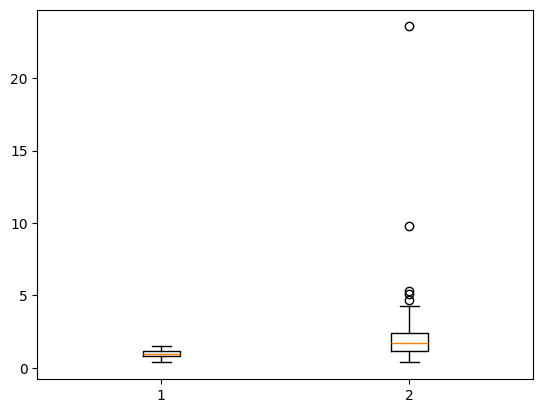

In [ ]:
#compare estimation errors for the two methods; left - two-stage, right - probit IV
plt.boxplot([tau_err1, tau_err[np.argwhere(tau_err < 100)].flatten()])